In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
np.random.seed(121)
def logpdfTarget (x):
    lnp = -(1/2) * (x.T).dot(x)
    return(lnp)

In [2]:
d = 100
Sigma_minus1 = wishart.rvs(df=d,scale=np.eye(d))
cov = np.linalg.inv(Sigma_minus1)
sum(sum(cov>0.99))/2

1155.0

In [3]:
nround = int(5*10e4)
burnin = int(10e3)
x = np.random.random(d) - 0.5
y = np.zeros(nround*d).reshape(nround,d)
accept = np.zeros(d)
mu_star = 0.1
kernel = 'MirrorU'
time_begin = time.time()
random_result = (np.random.random(size = len(range(-burnin,nround))*d)-0.5) * np.sqrt(12)
sigmaset = np.arange(0.1,2.1,0.1)
target_reuslt = {}

Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
for sigma in sigmaset:
    begin_loop = time.time()
    for j in range(-burnin,nround):
        if (j==0):
            count = 0; accept = np.zeros(d);
        for i in range(d):
            initial = x.copy()
            pi_old = logpdfTarget(initial)
            if (kernel == 'Uniform'):
                initial[i] += (np.random.random()-0.5) * np.sqrt(12) * sigma    #Uniform 
            elif (kernel == 'Gaussian'):
                initial[i] += np.random.normal() * sigma                        #Gaussian
            elif (kernel == 'MirrorU'):
                NewCenter = 2 * mu_star - initial[i]
                initial[i] = NewCenter + random_result[(j+burnin)*d+i] * sigma   #Mirror Uniform
            else:
                sys.exit('No such kernel exists')
            pi_new = logpdfTarget(initial)
            pi_dif = pi_new - pi_old
            if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                x = initial
                accept[i] += 1
        if (j>=0):
            y[j,:] = x

    eff = Eff_IntegratedCorrelationTime(y[:,0])
    exx2 = sum(np.square(y[:,0][1:] - y[:,0][:-1]))
    rho = [rho_k(y[:,0],i) for i in range(1,11)]
    Eff.append(eff)
    Pjump.append(accept[0]/nround)
    Exx2.append(exx2/nround)
    Rho.append(rho)
    Sample.append(y[:,0].copy())
    print ('sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept[0]/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
#     print('协方差矩阵: \n',np.cov(np.vstack([y[:,i] for i in range(d)])))
print('总共用时: %f'% (time.time()-time_begin))

sigma:0.1|eff:0.2104|Pjump:0.9207|Exx2:3.3972|rho1:-0.7007|rho2:0.5575|Time:317.1
sigma:0.2|eff:0.8235|Pjump:0.9082|Exx2:3.3523|rho1:-0.6677|rho2:0.4972|Time:316.89
sigma:0.30000000000000004|eff:1.4771|Pjump:0.8834|Exx2:3.1732|rho1:-0.5901|rho2:0.3873|Time:317.38
sigma:0.4|eff:1.8569|Pjump:0.8534|Exx2:2.9723|rho1:-0.493|rho2:0.277|Time:320.44
sigma:0.5|eff:1.8524|Pjump:0.8217|Exx2:2.8089|rho1:-0.4009|rho2:0.1874|Time:310.59
sigma:0.6|eff:1.6825|Pjump:0.7909|Exx2:2.6353|rho1:-0.318|rho2:0.1199|Time:316.05
sigma:0.7000000000000001|eff:1.5262|Pjump:0.7605|Exx2:2.4566|rho1:-0.2386|rho2:0.0668|Time:326.2
sigma:0.8|eff:1.33|Pjump:0.728|Exx2:2.3435|rho1:-0.1614|rho2:0.032|Time:323.46
sigma:0.9|eff:1.1557|Pjump:0.6992|Exx2:2.2048|rho1:-0.0904|rho2:0.0128|Time:318.73
sigma:1.0|eff:1.0334|Pjump:0.671|Exx2:2.0542|rho1:-0.0251|rho2:0.0057|Time:312.59
sigma:1.1|eff:0.9319|Pjump:0.6427|Exx2:1.9573|rho1:0.0288|rho2:0.0062|Time:321.67
sigma:1.2000000000000002|eff:0.8256|Pjump:0.617|Exx2:1.8332|rho1:0.

In [5]:
target_result = {}
target_result['100Normal'] = [Eff,Pjump,Exx2,Rho,Sample]
np.save('100Dimensional_target_result_mean0.1',target_result)

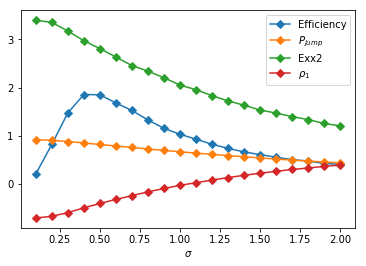

In [12]:
label = ['Efficiency','$P_{jump}$','Exx2']
rho1 = [target_result['100Normal'][3][i][0] for i in range(len(sigmaset))]
[plt.plot(sigmaset,target_result['100Normal'][i],marker='D',label=label[i]) for i in range(3)]
plt.plot(sigmaset,rho1,marker='D',label='$\\rho_1$')
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.savefig('100Normal_TrueMean0.1.eps', format='eps', dpi=1000)
plt.show()

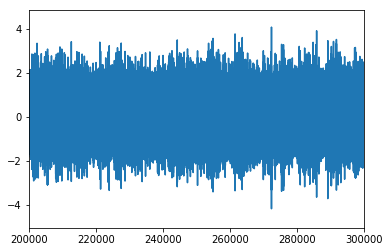

In [14]:
plt.plot(target_result['100Normal'][4][3])
plt.xlim(200000,300000)
plt.savefig('100Normal_TrueMean_TracePlot0.1.eps', format='eps', dpi=1000)
plt.show()